## import

In [116]:
try:
  import iminuit
  from iminuit import Minuit
  from iminuit.cost import LeastSquares
except:
  print('Error Initialising Iminuit')

In [117]:
try:
  from Minuit_newClass import ExtendedMinuit
except:
  print("error initialising Extended Minuit")

In [118]:
from IPython.display import Latex
import sympy as sp

In [119]:
from random import random
import scipy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axis import Axis

## funcs

In [120]:
def rZeros(arr):
    '''
        returns array without zero values
        
        `arr` numpy array
    '''
    return [arr[i] for i in np.nonzero(arr)]

In [121]:
#function for removing Nan values from a numpy array
def rNan(arr): return arr[~np.isnan(arr)]

In [122]:
def grafico(x,y,xerr,yerr, title, xlabel='x', ylabel='y', save=False):

  fig,ax = plt.subplots(1,1)

  ax.scatter(x,y, c='k')
  ax.errorbar(x,y,xerr=xerr,yerr=yerr,linestyle='None', color='k', markersize=8, capsize=5, alpha=0.5)
  # ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  if save:  plt.savefig(title+'.pdf')
  return ax

In [123]:
def visualize_minuit(my_minuit,xlabel='x',ylabel='y',xerr=0 ,yerr=0, labels='data'):

  data = my_minuit.visualize
  # plt.close()
  # fig,ax = plt.subplots(1,1)

  # ax.scatter(data[0][0],data[0][1], c='k')
  # ax.errorbar(data[0][0],data[0][1],xerr=xerr,yerr=yerr,linestyle='None', color='k', markersize=8, capsize=5, alpha=0.5)

  # ax.plot(data[1][0],data[1][1], c='r')
  # ax.set_xlabel(xlabel)
  # ax.set_ylabel(ylabel)
  # ax.legend(labels)

  return data

In [124]:
#@title Test ipotesi
def draw_p_value(fval, ndof, x_limit = 40):
  '''draws pvalue
  Values
  -------

    `fval` : chi2 value

    `ndof` : degrees of freedom
    `x_limit` : chi2 value limit for integral (don't change)
  '''

  x = np.linspace(0,x_limit, 1000)
  y = [sc.stats.chi2.pdf(i,df=ndof) for i in x]

  section = np.arange(fval, x_limit)
  plt.fill_between(section,sc.stats.chi2.pdf(section,df=ndof), alpha=.4)
  plt.title('Test $\chi^2$')
  plt.xlabel(r'$\chi^2$')
  plt.ylabel('$pdf(\chi^2)$')
  plt.legend([r'$\tilde\chi^2$ '+f'= {round(fval/ndof,2)} \n p-value = {round(1 - sc.stats.chi2.cdf(fval,ndof),3)*100}%'])
  plt.plot(x,y)

def t_value(tvalue, df,xlim = 7, alpha = 0.05 ):
  '''
    Values:
    -------

    `tvalue` : t Student test Value
    `df` : dergrees of freedom
    `xlim` : limit for integration (don't change)
  '''

  x = np.linspace(-xlim,xlim,2000)
  y = [ sc.stats.t.pdf(i,df) for i in x]

  section1 = np.linspace(-xlim,-tvalue)
  plt.fill_between(section1,sc.stats.t.pdf(section1,df=df), alpha=.4, color='b')

  section2 = np.linspace(tvalue, xlim)
  plt.fill_between(section2,sc.stats.t.pdf(section2,df=df), alpha=.4, color='b')

  plt.title('t Test')
  plt.xlabel(r't')
  plt.ylabel('pdf(t)')
  plt.legend([r'$\alpha$'+f' = {round((1-sc.stats.t.cdf(tvalue,df=df))*2, 4)}'])
  plt.plot(x,y)
  return (1-sc.stats.t.cdf(tvalue,df=df))*2

In [125]:
#@title Error Propagation no Covariance

def formula_errori(parametri:str, formula:str, latex_ = False):

    #convert from str to sympy
    parametri = sp.sympify(parametri)
    formula = sp.simplify(formula)
    sigmas = sp.symbols([f'sigma_{var}' for var in parametri])
    i,exp = 0,0

    for val in parametri:

        #squared partial derivatives and sigmas
        exp += sp.diff(formula,val)**2 * sigmas[i]**2
        i+=1

    exp = sp.sqrt(exp)

    if latex_: return '$'+sp.latex(exp)+'$'

    return (exp)

def valuta_errori(formula_errori:str, values:dict, errors:dict, x:dict=None):

  #convert minuit values method to dict
  params = values.keys()

  #sustitute numerical values
  expr = formula_errori.subs(values)

  for val in errors:

    #substitute numerical for sigmas
    expr = expr.subs(f'sigma_{val}', errors[val])

  if x != None: expr = expr.subs(x)

  return expr

In [126]:
# @title media pesata
def media_pesata(x,err) -> tuple['media','sigma']:

  x_ = np.array(x)
  err_ = np.array(err)

  if x_.shape != err_.shape:
    raise Exception('Size mismatch, control arrays!')
    return

  s1,s2 = 0,0
  for i,j in zip(x_,err_):

    s1 += i/j**2
    s2 += 1/j**2

  media = s1/s2
  sigma = np.sqrt(float(1/s2))

  return media,sigma

In [127]:
def sn(t,dec=1):
    return ("{:."+f"{dec}"+"e}").format(t)

# Data

In [128]:
data = 'https://docs.google.com/spreadsheets/d/1opp5UuS4x_MxOkC9whXrOPMLZohAEA4LmKT7oxHks8M/export?format=xlsx'

In [129]:
df = pd.read_excel(data,sheet_name=None)
print(df.keys())

dict_keys(['FP 1', 'FP 2', 'M 1', 'M 2', 'M 4', 'Righello'])


# Fabry Perot 1

In [130]:
fp1 = df['FP 1']
angolo = fp1[r'$\theta_N$'].to_numpy()
N_fp1 = fp1['N'].to_numpy()
cs_angolo = np.cos(angolo)

In [131]:
print(N_fp1)
N_fp1 = [5,4,3,2,1,0]

[0 1 2 3 4 5]


In [132]:
g = grafico(angolo,N_fp1,0.001,1,'Dati',save=True)
plt.close()

In [133]:
l_laser = 633*1e-9
def f1(x,a,d):
  return (x*l_laser)/(2*d) + a*(l_laser/(4*np.pi*d))

In [134]:
raggi = fp1['dy (raddio cerchio)']
dist = fp1['dx']

In [135]:
formula = 'atan(dy/dx)'
err = formula_errori('dy,dx',formula,True)
Latex(r'$\sigma_\theta$ ='+err)

<IPython.core.display.Latex object>

In [136]:
#@title errore angoli
def errore_angoli(dx,dy, errx=1e-1, erry=1e-1):
  formula = 'atan(dy/dx)'
  err = formula_errori('dy,dx',formula,False)

  err_ang = []

  dy=np.array(dy)
  if 1 == dy.size:
    values = {'dy':dy,
              'dx':dx
              }
    errors = {'dy':erry,
              'dx':errx
              }

    return valuta_errori(err, values, errors)

  for i,j in zip(dy,dx):

    values = {'dy':i,
              'dx':j
              }
    errors = {'dy':erry,
              'dx':errx
              }

    a = valuta_errori(err, values, errors)
    err_ang.append(a)
  return err_ang

In [137]:
formula = 'cos(atan(dy/dx))'
err = formula_errori('dy,dx',formula,True)
Latex(err)

<IPython.core.display.Latex object>

In [138]:
#@title errore angoli
def errore_angoli_2(dx,dy, errx=1e-1, erry=1e-1):
  formula = 'cos(atan(dy/dx))'
  err = formula_errori('dy,dx',formula,False)

  err_ang = []

  dy=np.array(dy)
  if 1 == dy.size:
    values = {'dy':dy,
              'dx':dx
              }
    errors = {'dy':erry,
              'dx':errx
              }

    return valuta_errori(err, values, errors)

  for i,j in zip(dy,dx):

    values = {'dy':i,
              'dx':j
              }
    errors = {'dy':erry,
              'dx':errx
              }

    a = valuta_errori(err, values, errors)
    err_ang.append(a)
  return err_ang

In [139]:
err_angoli_fp1 = errore_angoli(dist,raggi,errx=1,erry=.1)
print(err_angoli_fp1)

[0.000584606756383662, 0.000589969140009720, 0.000595897746141743, 0.000601951160935960, 0.000607231381395708, 0.000612101933556783]


In [140]:
formula = 'cos(theta)'
e = formula_errori('theta,', formula,True)
Latex(r'$\sigma_{cos(\theta)} = $ '+e)

<IPython.core.display.Latex object>

In [141]:
# Errore cos(angoli)
formula = 'cos(theta)'
expr = formula_errori('theta,', formula)

err_cs_angoli = []
for i,j in zip(angolo,err_angoli_fp1):

  val={'theta':i}
  err={'theta':j}

  a = valuta_errori(expr, val,err)
  err_cs_angoli.append(a)
  print(a)

3.75177473360424e-6
8.94832738579291e-6
1.25131788891826e-5
1.54475661267082e-5
1.77063353503873e-5
1.96314394762086e-5


In [142]:
err_cs_angoli_2 = errore_angoli_2(dist,raggi,errx=1,erry=.1)
print(err_cs_angoli_2)

[3.75177473344757e-6, 8.94832738376225e-6, 1.25131788871925e-5, 1.54475661250350e-5, 1.77063353524467e-5, 1.96314394749472e-5]


In [143]:
c = LeastSquares(N_fp1, cs_angolo, err_cs_angoli_2, f1)
m = Minuit(c, a=61.91e3, d=3.1185e-3)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.066 (χ²/ndof = 0.3)      │              Nfcn = 44               │
│ EDM = 8.44e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │ 61.8930e3 │ 0.0031e3  │            │            │         │         │       │
│ 1 │ d    │3.11935e-3 │0.00016e-3 │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────┐
│   │             a             d │
├───┼─────────────────────────────┤
│ a │          9.61 482.989638e-9 │
│ d │ 482.989638e-9      2.44e-14 │
└───┴─────────────────────────────┘

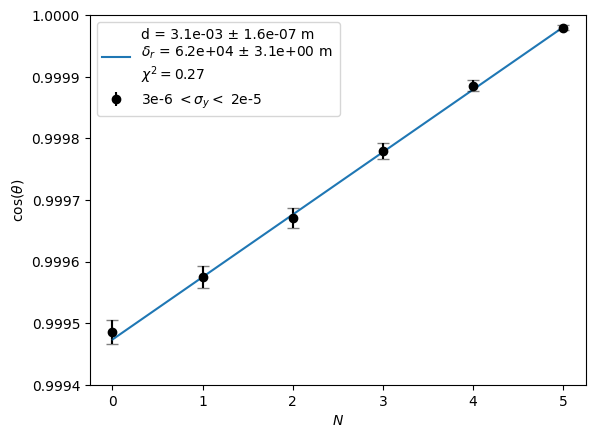

In [144]:
label = [ f"d = {sn(m.values['d'],1)} ± {sn(m.errors['d'],1)} m \n$\delta_r$ = {sn(m.values['a'],1)} ± {sn(m.errors['a'],1)} m \n$\chi^2 = {round(m.fval/m.ndof,2)}$", "3e-6 $ < \sigma_y < $ 2e-5"]

m.visualize()
plt.ylim(0.9994,1.0)
plt.errorbar(N_fp1, cs_angolo, err_cs_angoli_2, linestyle='None',fmt='.k',capsize=4, alpha=0.5)
plt.xlabel('$ N$')
plt.ylabel(r'cos($\theta$)')
plt.legend(label)
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
plt.savefig('fp1_data.pdf',bbox_inches='tight')

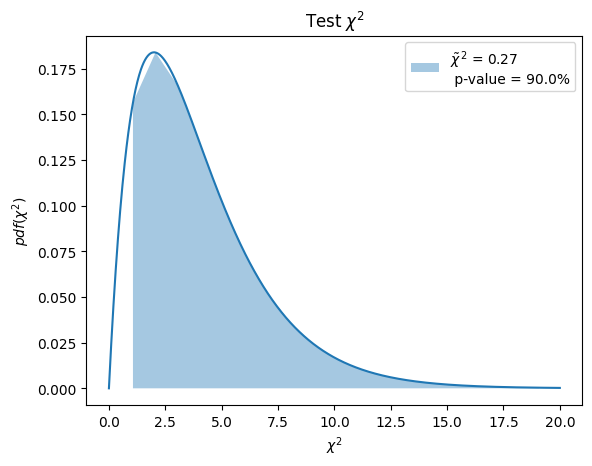

In [145]:
draw_p_value(m.fval,m.ndof,x_limit=20)
plt.savefig('fp1_pvalue.pdf')

# Fabry Perot 2

In [146]:
fp2 = df['FP 2']
N_fp2 = fp2['N'][6:]
d_micr_fp2 = fp2['d misurato'][6:]
d_acc = fp2['d accumulato'][6:]
# ang_fp2 = fp2['angolo']
# print(fp2.keys())

In [147]:
angolo_fp2 = np.arctan(2.4/171.4)
print('Angolo = ',angolo_fp2)

Angolo =  0.014001418705773967


In [148]:
ang_err_fp2 = errore_angoli(171.4, 2.4, errx=1, erry=0.3)
print(ang_err_fp2)

0.00175185370892223


In [149]:
Latex(r'$\theta$'+f' = {sn(angolo_fp2,2)} $\pm$ {sn(ang_err_fp2)}')

<IPython.core.display.Latex object>

In [150]:
#@title Calcolo d
d_fp2 = []
for i in N_fp2:
  d_fp2.append(i*l_laser / (2*np.cos(angolo_fp2)))

print(d_fp2)

[1.4560427187760837e-05, 1.4876958213581724e-05, 1.4243896161939948e-05, 1.5826551291044388e-05, 1.5193489239402612e-05, 1.4876958213581724e-05, 1.55100202652235e-05, 1.5193489239402612e-05, 1.4876958213581724e-05, 1.5193489239402612e-05, 1.4876958213581724e-05, 1.55100202652235e-05, 1.5826551291044388e-05, 1.55100202652235e-05, 1.5193489239402612e-05, 1.5193489239402612e-05, 1.5826551291044388e-05, 1.4876958213581724e-05, 1.55100202652235e-05, 1.5193489239402612e-05]


In [151]:
#@title Errore d
formula = r'(n*l)/(2*cos(theta))'
expr = formula_errori('n,theta', formula, False)

d_err_fp2 = []

for i in N_fp2:

  values = {'n':i,  'theta':angolo_fp2, 'l':l_laser}
  errors = {'n':1,  'theta':ang_err_fp2}

  d_err_fp2.append(valuta_errori(expr, values, errors))

print(d_err_fp2)

[3.16531227331692e-7, 3.16531236188261e-7, 3.16531218665587e-7, 3.16531263900747e-7, 3.16531245235292e-7, 3.16531236188261e-7, 3.16531254472788e-7, 3.16531245235292e-7, 3.16531236188261e-7, 3.16531245235292e-7, 3.16531236188261e-7, 3.16531254472788e-7, 3.16531263900747e-7, 3.16531254472788e-7, 3.16531245235292e-7, 3.16531245235292e-7, 3.16531263900747e-7, 3.16531236188261e-7, 3.16531254472788e-7, 3.16531245235292e-7]


In [152]:
#@title Media pesata d
d, err_d = media_pesata(d_fp2, d_err_fp2)
Latex(f'd = {sn(d)}  $\pm$ {  sn(err_d)}')

<IPython.core.display.Latex object>

In [153]:
formula = 'd1/d2'
expr = formula_errori('d1,d2', formula)

values = {'d1':d, 'd2':15e-6}
errors = {'d1':err_d, 'd2':1e-7}

delta_d_err = valuta_errori(expr, values, errors)
print(delta_d_err)

0.00823792071696336


In [154]:
delta_d = d/15e-6
Latex(f'd1/d2 = {delta_d} $\pm$ {delta_d_err}')

<IPython.core.display.Latex object>

# Michelson 1

In [155]:
m1 = df['M 1']
dx = m1['dx [cm]']
dy = m1['dy [cm]']
N_m1 = m1['N non mod']

In [156]:
ang_m1 = []

for i,j in zip(dx,dy):
  ang_m1.append(np.arctan2(j,i))
print(ang_m1)

[0.020324699459390357, 0.020324699459390357, 0.020324699459390357, 0.020324699459390357, 0.020324699459390357, 0.020324699459390357, 0.020324699459390357, 0.020324699459390357, 0.020324699459390357, 0.020324699459390357, 0.020324699459390357, 0.020324699459390357, 0.02046331716402653, 0.02046331716402653, 0.02046331716402653, 0.02046331716402653, 0.02046331716402653, 0.02046331716402653, 0.02046331716402653, 0.02046331716402653]


In [157]:
err_ang_m1 = errore_angoli(dx,dy,errx=5, erry=0.3)
print(err_ang_m1)

[0.00178779540990823, 0.00178779540990823, 0.00178779540990823, 0.00178779540990823, 0.00178779540990823, 0.00178779540990823, 0.00178779540990823, 0.00178779540990823, 0.00178779540990823, 0.00178779540990823, 0.00178779540990823, 0.00178779540990823, 0.00180124986942475, 0.00180124986942475, 0.00180124986942475, 0.00180124986942475, 0.00180124986942475, 0.00180124986942475, 0.00180124986942475, 0.00180124986942475]


In [158]:
cs_ang_m1 = np.cos(ang_m1)

formula = 'cos(theta)'
expr = formula_errori('theta,', formula)
err_cs_ang_m1 = []

for i,j in zip(ang_m1, err_ang_m1):

  values = {'theta':i}
  errors = {'theta':j}

  err_cs_ang_m1.append(valuta_errori(expr,values, errors))

In [159]:
# calcolo d
d_m1 = []
for i,j in zip(N_m1,ang_m1):
  d_m1.append(i*l_laser / (2*np.cos(j)))


# Errore d
formula = r'(n*l)/(2*cos(theta))'
expr = formula_errori('n,theta', formula, False)

d_err_m1 = []

for i,j,k in zip(N_fp2,ang_m1,err_ang_m1):

  values = {'n':i,  'theta':j, 'l':l_laser}
  errors = {'n':1,  'theta':k}

  d_err_m1.append(valuta_errori(expr, values, errors))

for i,j in zip(d_m1,d_err_m1):
  print('d = ',i,'±',j)

d =  1.4878573014428188e-05 ± 3.16565825621722e-7
d =  1.4562007631142482e-05 ± 3.16565845062752e-7
d =  1.4245442247856774e-05 ± 3.16565806598777e-7
d =  1.5195138397713894e-05 ± 3.16565905894354e-7
d =  1.5195138397713894e-05 ± 3.16565864921867e-7
d =  1.5511703780999598e-05 ± 3.16565845062752e-7
d =  1.5195138397713894e-05 ± 3.16565885199068e-7
d =  1.3928876864571068e-05 ± 3.16565864921867e-7
d =  1.4878573014428188e-05 ± 3.16565845062752e-7
d =  1.5511703780999598e-05 ± 3.16565864921867e-7
d =  1.4562007631142482e-05 ± 3.16565845062752e-7
d =  1.5195138397713894e-05 ± 3.16565885199068e-7
d =  1.4878615081608797e-05 ± 3.16566816100828e-7
d =  1.4562048803276696e-05 ± 3.16566794805204e-7
d =  1.5195181359940897e-05 ± 3.16566773939793e-7
d =  1.4245482524944592e-05 ± 3.16566773939793e-7
d =  1.5511747638272998e-05 ± 3.16566816100828e-7
d =  1.4245482524944592e-05 ± 3.16566753504595e-7
d =  1.5511747638272998e-05 ± 3.16566794805204e-7
d =  1.4562048803276696e-05 ± 3.16566773939793e-7


In [160]:
print(d_err_m1)

[3.16565825621722e-7, 3.16565845062752e-7, 3.16565806598777e-7, 3.16565905894354e-7, 3.16565864921867e-7, 3.16565845062752e-7, 3.16565885199068e-7, 3.16565864921867e-7, 3.16565845062752e-7, 3.16565864921867e-7, 3.16565845062752e-7, 3.16565885199068e-7, 3.16566816100828e-7, 3.16566794805204e-7, 3.16566773939793e-7, 3.16566773939793e-7, 3.16566816100828e-7, 3.16566753504595e-7, 3.16566794805204e-7, 3.16566773939793e-7]


In [161]:
d_m1_pes, d_m1_pes_err = media_pesata(d_m1,d_err_m1)
print(d_m1_pes,d_m1_pes_err)

1.48785898529674e-5 7.078636074969791e-08


In [162]:
formula = 'd1/d2'
expr = formula_errori('d1,d2',formula)

values = {'d1':d_m1_pes,'d2':15e-6}
errors = {'d1':d_m1_pes_err,'d2':0.}


errore_calibro = valuta_errori(expr,values,errors)

In [163]:
print(d_m1_pes/15e-6, errore_calibro)
delta_d_2 = d_m1_pes/15e-6

0.991905990197824 0.00471909071664653


In [164]:
print(f'd1/d2 = {delta_d} ± {delta_d_err}')
print(f'd1/d2 = {delta_d_2} ± {errore_calibro}')

d1/d2 = 1.01289928056221 ± 0.00823792071696336
d1/d2 = 0.991905990197824 ± 0.00471909071664653


In [165]:
def t_test(mean, std, n):

    mean_ = np.array(mean)
    std_ = np.array(std)
    n_ = np.array(n)

    if mean_.size != 2 or std_.size != 2 or n_.size != 2:
        print(mean_.shape, std_.shape, n_.shape)
        raise Exception('Array size error!')
    
    return float(abs(mean[1] - mean[0]) / np.sqrt( float(std[0]**2/n[0]) + float(std[1]**2/n[1]) ))

In [166]:
t = t_test((delta_d,delta_d_2),(delta_d_err,errore_calibro),(N_fp2.size, N_m1.size))
print('t = ',t)
print('pvalue = ',1-sc.stats.t.cdf(t,2))

t =  9.889019289610225
pvalue =  0.005035745134300829


# Michelson 2: Pressione

In [167]:
m2 = df['M 2']
p = m2['P']*1e3
n_m2 = m2['N']
p_medie = rNan(m2['p_medie'].to_numpy())
n_medie = rNan(m2['N_medie'].to_numpy())
err_n_medie = rNan(m2['errore N_medie'].to_numpy())

In [168]:
p_amb = 101.3e3 #Pascal
p = np.abs(p)
p_medie = np.abs(p_medie)*1e3

In [169]:
d = 3.215e-2
l_laser_o = l_laser/1.000
def pressione(x,m):
  return 2*d*m*x / l_laser_o

In [170]:
print((1.00029-1)/101.3e3)

2.8627838104629955e-09


In [171]:
c = LeastSquares(p, n_m2, 1, pressione)
m = Minuit(c, m=2.86278e-09)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 24.12 (χ²/ndof = 0.5)      │              Nfcn = 11               │
│ EDM = 5.94e-15 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │ 2.055e-9  │ 0.029e-9  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        m │
├───┼──────────┤
│ m │ 8.71e-22 │
└───┴──────────┘

In [172]:
c = LeastSquares(p_medie, n_medie, err_n_medie, pressione)
m = Minuit(c, m=2.86278e-09)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9.693 (χ²/ndof = 1.1)      │              Nfcn = 11               │
│ EDM = 4.62e-16 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │ 2.055e-9  │ 0.029e-9  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        m │
├───┼──────────┤
│ m │ 8.64e-22 │
└───┴──────────┘

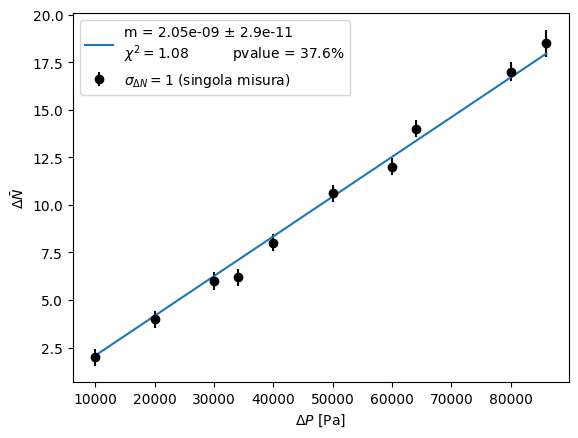

In [173]:
label = [ f"m = {sn(m.values['m'],2)} ± {sn(m.errors['m'],1)} \n$\chi^2 = {round(m.fval/m.ndof,2)}$ \t pvalue = {round((1-sc.stats.chi2.cdf(m.fval,m.ndof))*100,1)}%", "$\sigma_{\Delta N} = 1$ (singola misura)"]

m.visualize()
# plt.errorbar(p_medie, n_medie, err_n_medie, linestyle='None',fmt='.k',capsize=4, alpha=0, elinewidth=0)
plt.ylabel(r'$ \Delta \bar{N}$')
plt.xlabel(r'$\Delta P $ [Pa]')
plt.legend(label)
# plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
plt.savefig('pressione_data.pdf',bbox_inches='tight')

In [174]:
formula = 'm*P + 1'
expr = formula_errori('m,P', formula,False)
n_aria_err = valuta_errori(expr, {'m':m.values['m'],'P':p_amb}, {'m':m.errors['m'], 'P':2e3})

n_aria = (m.values['m']*p_amb)+1

In [175]:
print('n aria = ',n_aria,'±', n_aria_err)

n aria =  1.00020812409412 ± 5.07462596163854e-6


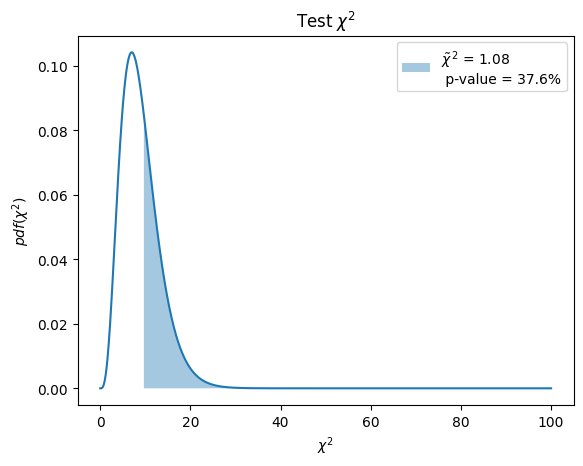

In [176]:
draw_p_value(m.fval,m.ndof, x_limit=100)

# Michelson 4

In [177]:
m4 = df['M 4']
ang_m4 = m4['angoli radianti']
N_m4 = m4['N']

In [178]:
def n(t,N):
  d = 5.35*1e-3
  return (2*d - N*l_laser)*(1 - np.cos(t)) / (2*d*(1- np.cos(t))- N*l_laser)

In [179]:
n_vetro = []
for i,j in zip(ang_m4,N_m4):
  n_vetro.append(n(i,j))
print(n_vetro)

[1.5537322443843748, 1.8574526011661765, 1.758500305533297, 1.7854387365292619, 1.7854387365292619, 1.8576422136563597, 1.7550562524542042, 1.8093424964989777, 1.8093424964989777, 1.6754894638478464, 1.5265957728829693, 1.6083224751348342, 1.6231822873395039, 1.65301562931094, 1.6231822873395039, 1.772770562223423, 1.703044950994163, 1.7365023370602035, 1.739794991635314, 1.8155830142664882, 1.8155830142664882]


In [180]:
def sturges(n):
  return int(1 + 3.322*np.log10(n))

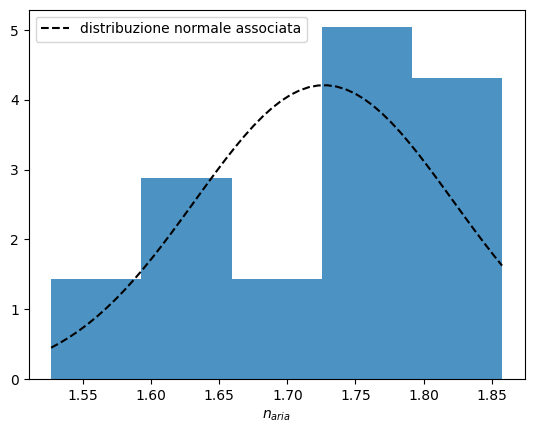

In [191]:
plt.hist(n_vetro, density=True, bins=sturges(len(n_vetro)), alpha=0.8)

x = np.linspace(np.min(n_vetro),np.max(n_vetro))
y = [sc.stats.norm.pdf(i,np.mean(n_vetro),np.std(n_vetro)) for i in x]

plt.xlabel('$n_{vetro}$')
plt.plot(x,y, color='k', linestyle='--')
plt.legend(['distribuzione normale associata'])
plt.savefig('indice_vetro.pdf')

In [192]:
print(np.mean(n_vetro), np.std(n_vetro))

1.7269053747405982 0.09482392867078411
